# MILVUS Demo - Hybrid Search + Grouping Search with Connections.connect 
### Disclaimers

- Use only Projects and Spaces that are available in the watsonx context.
- Kindly use your own dataset .

#### Overview

This notebook showcases advanced search techniques by combining hybrid search with reranking strategies and leveraging the **group_by_field** feature for similarity search within groups to enhance results and remove redundancy. It demonstrates how to effectively utilize both traditional search methods (e.g., keyword-based) and modern embedding-based techniques to improve search accuracy and relevance, catering to datasets that demand robust and efficient retrieval capabilities.
#### Audience

This notebook is designed for people interested in building or improving search systems. Some familiarity with Python programming, search algorithms, and basic machine learning concepts is recommended. The code runs with Python 3.10 or later.

#### Learning Goal

This notebook demonstrates similarity search support in watsonx.data using hybrid search along with grouping search, introducing commands for:
- Connecting to Milvus
- Creating collections
- Creating indexes
- Generating Dense Embeddings
- Generating Sparse Embeddings
- Ingesting data
- Data retrieval

#### About Milvus
Milvus is an open-source vector database designed specifically for scalable similarity search and AI applications. It's a powerful platform that enables efficient storage, indexing, and retrieval of vector embeddings, which are crucial in modern machine learning and AI tasks.  
To know more, visit [Milvus Documentation](https://milvus.io/docs/).

---

### Milvus: Three Fundamental Steps

1. **Data Preparation**  
   Collect and convert your data into high-dimensional vector embeddings. These vectors are typically generated using machine learning models, transforming text, images, audio, or other data types into dense numerical representations that capture semantic meaning and relationships.

2. **Vector Insertion**  
   Load the dense vector embeddings and sparse vector embeddings into Milvus collections or partitions. Milvus creates indexes to optimize subsequent search operations, supporting various indexing algorithms like IVF-FLAT and HNSW.

3. **Similarity Search**  
   Perform vector similarity searches by providing a query vector and a reranking weight. Milvus rapidly returns the most similar vectors from the collection based on defined metrics like cosine similarity, Euclidean distance, or inner product.

---

### Why Hybrid Search?

Hybrid vector search leverages the combined strengths of sparse and dense vectors to deliver more accurate and relevant results.  
- **Dense vectors**: Capture the deep semantic meaning of data, enabling better understanding and context-aware retrieval.  
- **Sparse vectors**: Effective for capturing specific features or exact matches, such as keyword occurrences.  

By integrating both semantic context and feature matching, hybrid search ensures an approach that outperforms either method alone, making it particularly powerful for real-world search scenarios.

---
### Why Grouping Search?
Grouping search in Milvus enhances search capabilities by allowing results to be grouped by the values of a specified field, enabling high-level data aggregation and improving the relevance and diversity of search results.

#### Key Benefits:
- **Improved Diversity**:
Grouping ensures that search results are more varied, avoiding duplicates or overly similar entries when entities share the same scalar field values.
Example: Instead of retrieving multiple books with the same title, grouping can return different categories of books discussing similar topics.

- **Enhanced Relevance**:
Grouping results by a specified field helps identify the most relevant documents, even when they are fragmented across multiple paragraphs or entities.
Example: If a document has multiple paragraphs matching the query, grouping can aggregate these paragraphs into a single result for better clarity.
- **Efficiency Gains**:
Milvus optimizes grouping searches directly during the ANN (Approximate Nearest Neighbor) search phase, reducing the need for manual post-processing, which is computationally expensive in large-scale queries.

---
### UseCase:
In this notebook, we have curated a small eyewear dataset to demonstrate Hybrid+Grouping Search . Initially, we will apply hybrid search, which combines dense and sparse representations for improved retrieval. Then, we will introduce grouping search to cluster similar results and observe how it enhances the overall relevance and diversity of search outcomes. Through this experiment, we aim to demonstrate the effectiveness of grouping search in refining search results.

---
### Key Workflow

1. **Definition** (once)
2. **Ingestion** (once)
3. **Retrieve relevant passage(s)** (for every user query)

---

### Contents

- Environment Setup
- Install packages
- Document data loading
- Create connection
- Ingest data
- Retrieve relevant data

---

### Environment Setup

Before using the sample code in this notebook, complete the following setup tasks:
- **Create a Watsonx.data instance** (a free plan is offered).  
   Information about creating a watsonx.data instance can be found [here](https://www.ibm.com/cloud/watsonx).


### Install required packages and PyMilvus SDK

In [1]:
!pip install --upgrade pymilvus
!pip install "pymilvus[model]"

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
from pymilvus import model
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
from pymilvus import AnnSearchRequest, WeightedRanker

### Connect to Milvus

In [3]:
connections.connect(
            alias='default',
            host="localhost",
            port='19530',
            secure=True,
            server_pem_path="/root/ibm-lh-dev/localstorage/volumes/infra/tls/cert.crt",
            server_name="localhost",
            user="ibmlhadmin",
            password="password")
print("Connected")
# Drop the collection
utility.drop_collection("sunglasses")

Connected


## For generating Image embeddings we have used CLIP model from openAI, you can choose model according to your dataset

In [4]:
# Load CLIP for image embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Data preparation

In [5]:
# Eyewear dataset having fields - "id" , " brand_name" ,"product_name","product_description","images"
data = [
    (1, "Lensify", "Shades11", "UV400 Protection, Funky heart shaped, Extended Nose Bridge", "/root/sunglass/1.png"),
    (2, "Colorbloc", "Shades12", "Blue Light Blocking, Scratch-Resistant Coating, Street Fashion", "/root/sunglass/2.png"),
    (3, "Lensify", "Shades13", "Photochromic Lenses,  Star shaped", "/root/sunglass/3.png"),
    (4, "Lensify", "Shades14", "Polarized Lenses, Impact-Resistant Polycarbonate, Hydrophobic Coating", "/root/sunglass/4.png"),
    (5, "Lensify", "Shades15", "High-Index (1.67) Lenses, Oleophobic Coating, Wide Field of Vision", "/root/sunglass/5.png"),
    (6, "Colorbloc", "Shades16", "Progressive Lenses, Lightweight Frame Design", "/root/sunglass/6.png"),
    (7, "Smartglass", "Shades17", "Single Vision Lenses, Anti-Glare Coating, Adjustable Temple Arms", "/root/sunglass/7.png"),
    (8, "Colorbloc", "Shades18", "Bifocal Lenses, Aspheric Lenses, UV400 Protection", "/root/sunglass/8.png"),
    (9, "Colorbloc", "Shades19", "Trifocal Lenses, Anti-Glare (AR) Coating, Wide Field of Vision", "/root/sunglass/9.png"),
    (10, "eyecon", "Shades20", "Scratch-Resistant Coating, Hydrophobic Coating, UV400 Protection", "/root/sunglass/10.png"),
    (11, "eyecon", "Shades21", "Photochromic Lenses, Anti-Glare Coating", "/root/sunglass/11.png"),
    (12, "eyecon", "Shades22", "Polarized Lenses, High-Index (1.74) Lenses, Impact-Resistant Material,Anti-Glare Coating", "/root/sunglass/12.png"),
    (13, "eyecon", "Shades23", "Anti-Glare Coating, Progressive Lenses, Adjustable Temple Arms", "/root/sunglass/13.png"),
    (14, "Brightly", "Shades24", "Aspheric Lenses, Lightweight Frame Design, Extended Nose Bridge", "/root/sunglass/14.png"),
    (15, "Brightly", "Shades25", "Impact-Resistant Trivex Lenses, Scratch-Resistant Coating, Hydrophobic Coating,Anti-Glare Coating", "/root/sunglass/15.png"),
    (16, "Brightly", "Shades26", "Wide Field of Vision, Anti-Glare Coating", "/root/sunglass/16.png"),
    (17, "Brightly", "Shades27", "Photochromic Lenses, UV400 Protection, High-Index (1.67) Lenses", "/root/sunglass/17.png"),
    (18, "Smartglass", "Shades28", "Bifocal Lenses, Impact-Resistant Polycarbonate, Scratch-Resistant Coating", "/root/sunglass/18.png"),
    (19, "Smartglass", "Shades29", "Trifocal Lenses, Lightweight Titanium Frame, Anti-Glare Coating", "/root/sunglass/19.png"),
    (20, "Smartglass", "Shades30", "UV400 Protection, Blue Light Blocking, Adjustable Temple Arms", "/root/sunglass/20.png"),
    (21, "Lensify", "Shades111", "Geek Glasses, Wide Field of Vision, Extended Nose Bridge", "/root/sunglass/21.png"),
    (22, "Colorbloc", "Shades112", "Blue Light Blocking, Scratch-Resistant Coating, UV400 Protection", "/root/sunglass/22.png"),
    (23, "Lensify", "Shades113", "Photochromic Lenses,Anti-Glare Coating, Adjustable Temple Arms", "/root/sunglass/23.png"),
    (24, "Lensify", "Shades114", "Polarized Lenses, Impact-Resistant Polycarbonate, Hydrophobic Coating", "/root/sunglass/24.png"),
    (25, "Lensify", "Shades115", "High-Index (1.67) Lenses, Oleophobic Coating, Wide Field of Vision", "/root/sunglass/25.png"),
    (26, "Colorlov", "Shades116", "Progressive Lenses, Lightweight Frame Design", "/root/sunglass/26.png"),
    (27, "Colorlov", "Shades117", "Single Vision Lenses, Anti-Fatigue Lenses, Adjustable Temple Arms", "/root/sunglass/27.png"),
    (28, "Colorlov", "Shades118", "Bifocal Lenses, Aspheric Lenses, Extended Nose Bridge", "/root/sunglass/28.png"),
    (29, "Colorlov", "Shades119", "Street Fashion, Anti-Glare (AR) Coating, Wide Field of Vision", "/root/sunglass/29.png"),
    (30, "eyecon", "Shades120", "Scratch-Resistant Coating, Hydrophobic Coating, Oleophobic Coating", "/root/sunglass/30.png"),
    (31, "eyecon", "Shades121", " Photochromic Lenses, Street Fashion", "/root/sunglass/31.png"),
    (32, "eyecon", "Shades122", "UV400 Protection, High-Index (1.74) Lenses, Impact-Resistant Material", "/root/sunglass/32.png"),
    (33, "eyecon", "Shades123", "Anti-Fatigue Lenses, Progressive Lenses, Adjustable Temple Arms", "/root/sunglass/33.png"),
    (34, "Brightly", "Shades124", "Aspheric Lenses, Lightweight Frame Design, Extended Nose Bridge", "/root/sunglass/34.png"),
    (35, "Brightly", "Shades125", "Impact-Resistant Trivex Lenses, Scratch-Resistant Coating, Hydrophobic Coating", "/root/sunglass/35.png"),
    (36, "Brightly", "Shades126", "Wide Field of Vision, Anti-Glare Coating", "/root/sunglass/36.png"),
    (37, "Brightly", "Shades127", "Photochromic Lenses, UV400 Protection, High-Index (1.67) Lenses", "/root/sunglass/37.png"),
    (38, "Smartlens", "Shades128", "Bifocal Lenses, Impact-Resistant Polycarbonate, Scratch-Resistant Coating", "/root/sunglass/38.png"),
    (39, "Smartlens", "Shades129", "Trifocal Lenses, Lightweight Titanium Frame, Wide Field of Vision", "/root/sunglass/39.png"),
    (40, "Smartlens", "Shades130", "Single Vision Lenses, Blue Light Blocking, Adjustable Temple Arms", "/root/sunglass/40.png")
]


## We are using splade model for generating sparse embeddings 

In [6]:
splade_ef = model.sparse.SpladeEmbeddingFunction(
    model_name="naver/splade-cocondenser-selfdistil", 
    device="cpu"
)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [7]:
def extract_image_embedding(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image from {image_path}")
        
        image = cv2.resize(image, (224, 224))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        inputs = clip_processor(images=image_rgb, return_tensors="pt")
        
        with torch.no_grad():
            embeddings = clip_model.get_image_features(**inputs)
        
        return embeddings.numpy().flatten()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros(512)

# Create Embeddings
image_embeddings = [extract_image_embedding(img_path) for _, _, _, _, img_path in data]
corpus = [row[3] for row in data]
sparse_embedding = splade_ef.encode_documents(corpus)

def convert_sparse_embedding(sparse_matrix):
    converted_data = []
    for row in sparse_matrix:
        dense_row = row.toarray().flatten()
        non_zero_indices = np.nonzero(dense_row)[0]
        
        row_dict = {
            int(idx): float(dense_row[idx]) 
            for idx in non_zero_indices
        }
        converted_data.append(row_dict)
    
    return converted_data

converted_sparse_data = convert_sparse_embedding(sparse_embedding)


## Create Milvus schema

[more about schema](https://www.ibm.com/docs/en/watsonx/watsonxdata/2.1.x?topic=milvus-connecting-service#taskconctmilvus__postreq__1)

In [8]:
# Define Schema
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="brand_name", dtype=DataType.VARCHAR, max_length=50),
    FieldSchema(name="product_name", dtype=DataType.VARCHAR, max_length=50),
    FieldSchema(name="product_description", dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name="image_path", dtype=DataType.VARCHAR, max_length=255),
    FieldSchema(name="image_embedding", dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name="sparse_embedding", dtype=DataType.SPARSE_FLOAT_VECTOR),
]

schema = CollectionSchema(fields, description="Hybrid search for sunglasses")
collection = Collection("sunglasses", schema)

## Create Index
 [more on indexes](https://www.ibm.com/docs/en/watsonx/watsonxdata/2.1.x?topic=milvus-connecting-service#taskconctmilvus__postreq__1)


In [9]:
# Create Indexes
collection.create_index("image_embedding", {
    "index_type": "IVF_FLAT", 
    "metric_type": "L2", 
    "params": {"nlist": 100}
})
collection.create_index("sparse_embedding", {
    "index_type": "SPARSE_INVERTED_INDEX", 
    "metric_type": "IP"
})

# Insert Data
entities = [
    [d[0] for d in data],       # IDs
    [d[1] for d in data],       # Brand names
    [d[2] for d in data],       # Product names
    [d[3] for d in data],       # Descriptions
    [d[4] for d in data],       # Image paths
    image_embeddings,            # Dense image embeddings
    converted_sparse_data,       # Sparse text embeddings
]
collection.insert(entities)
collection.load()

## Hybrid Search results Without Grouping Search

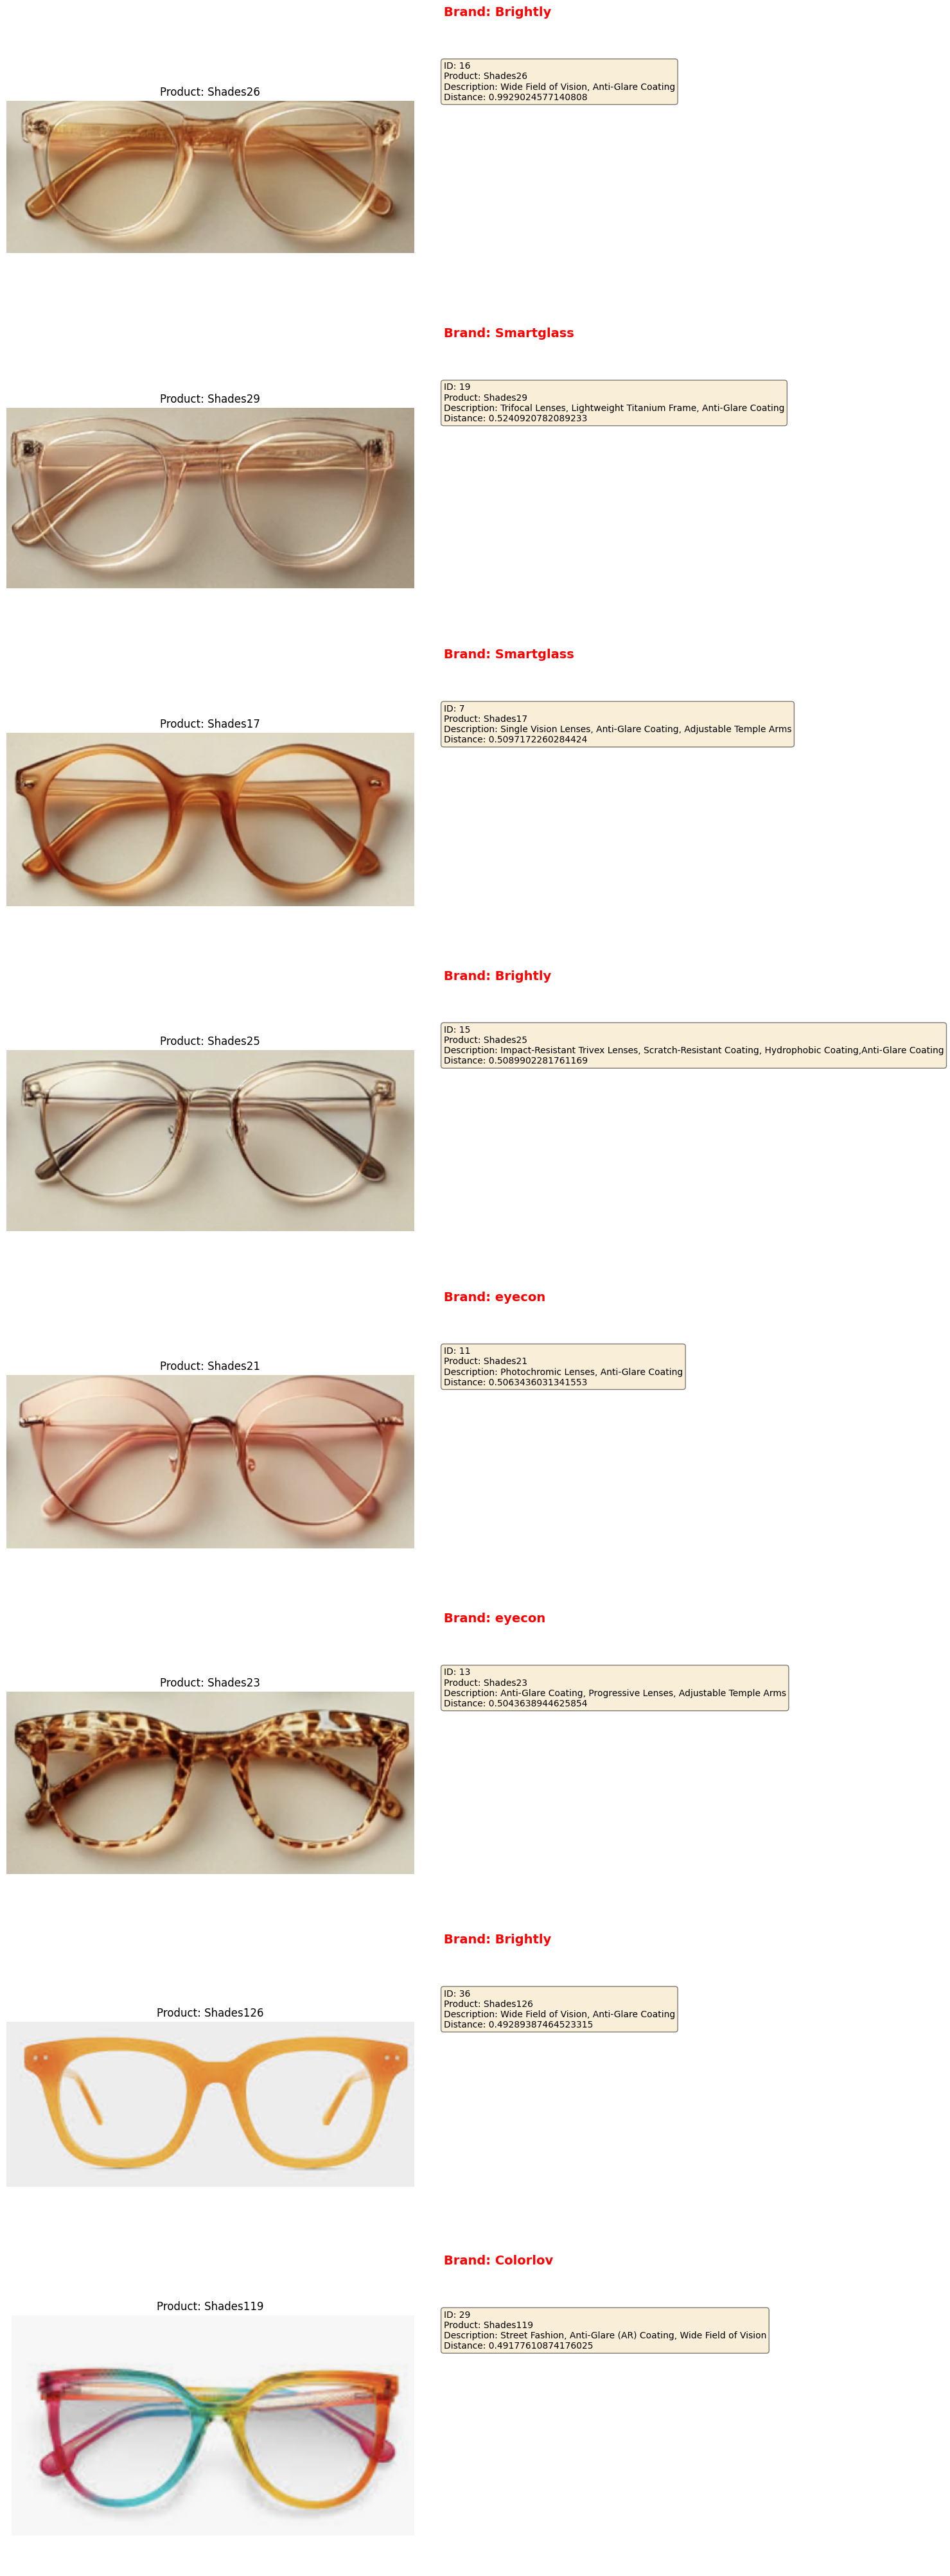

In [10]:
def hybrid_search(image_path, text_query, alpha=0.5, top_k=8):
    image_embedding = extract_image_embedding(image_path)
    splade_query_embedding = splade_ef.encode_queries([text_query])
    query_sparse_embedding = convert_sparse_embedding(splade_query_embedding)[0]

    search_param_image = {
        "data": [image_embedding],
        "anns_field": "image_embedding",
        "param": {
            "metric_type": "L2",
            "params": {"nprobe": 10}
        },
        "limit": top_k
    }
    request_image = AnnSearchRequest(**search_param_image)
    
    search_param_text = {
        "data": [query_sparse_embedding],
        "anns_field": "sparse_embedding",
        "param": {
            "metric_type": "IP",
            "params": {"drop_ratio_search": 0.2}
        },
        "limit": top_k
    }
    request_text = AnnSearchRequest(**search_param_text)
    
    rerank = WeightedRanker(alpha, 1 - alpha)

    collection.load()
    res = collection.hybrid_search(
        [request_image, request_text],
        rerank,
        limit=top_k,
        output_fields=[
            "id", 
            "brand_name", 
            "product_name", 
            "product_description", 
            "image_path"
        ]
    )
    
    return res[0]

def show_results(results):
    num_results = len(results)
    
    fig = plt.figure(figsize=(15, 5 * num_results), constrained_layout=True)
    
    gs = fig.add_gridspec(num_results, 2)
    
    for i, res in enumerate(results):
        entity = res.entity
        img_path = entity.get("image_path")
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax_img = fig.add_subplot(gs[i, 0])
        ax_img.imshow(img)
        ax_img.set_title(f"Product: {entity.get('product_name')}")
        ax_img.axis('off')
        
        ax_text = fig.add_subplot(gs[i, 1])
        brand_name = entity.get('brand_name')
        
        details = (
            f"ID: {entity.get('id')}\n"
            f"Product: {entity.get('product_name')}\n"
            f"Description: {entity.get('product_description')}\n"
            f"Distance: {res.distance}"
        )
        
        ax_text.text(0.05, 1.05, f"Brand: {brand_name}",
                     fontsize=14, color="red", fontweight="bold",
                     verticalalignment='bottom', horizontalalignment='left',
                     transform=ax_text.transAxes)
        
        ax_text.text(0.05, 0.9, details,
                     verticalalignment='top', horizontalalignment='left',
                     fontsize=10,
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                     transform=ax_text.transAxes)
        
        ax_text.axis("off")

    
    plt.show()
#Query - I am trying to find glasses which look similar to glasses with ID=16 having "Anti-Glare Coating"
image_path = "/root/sunglass/16.png"
text_query = "Anti-Glare Coating"

search_results = hybrid_search(image_path, text_query, alpha=0.5)

show_results(search_results)

#### In the above results, we can see that all the glasses closely match the query image and text, aligning with the desired quality. Additionally, multiple results are from the brand Brightly. To achieve more diverse results and limit the number of items per brand, we will apply grouping search.

## Hybrid Search Results with Grouping Search 

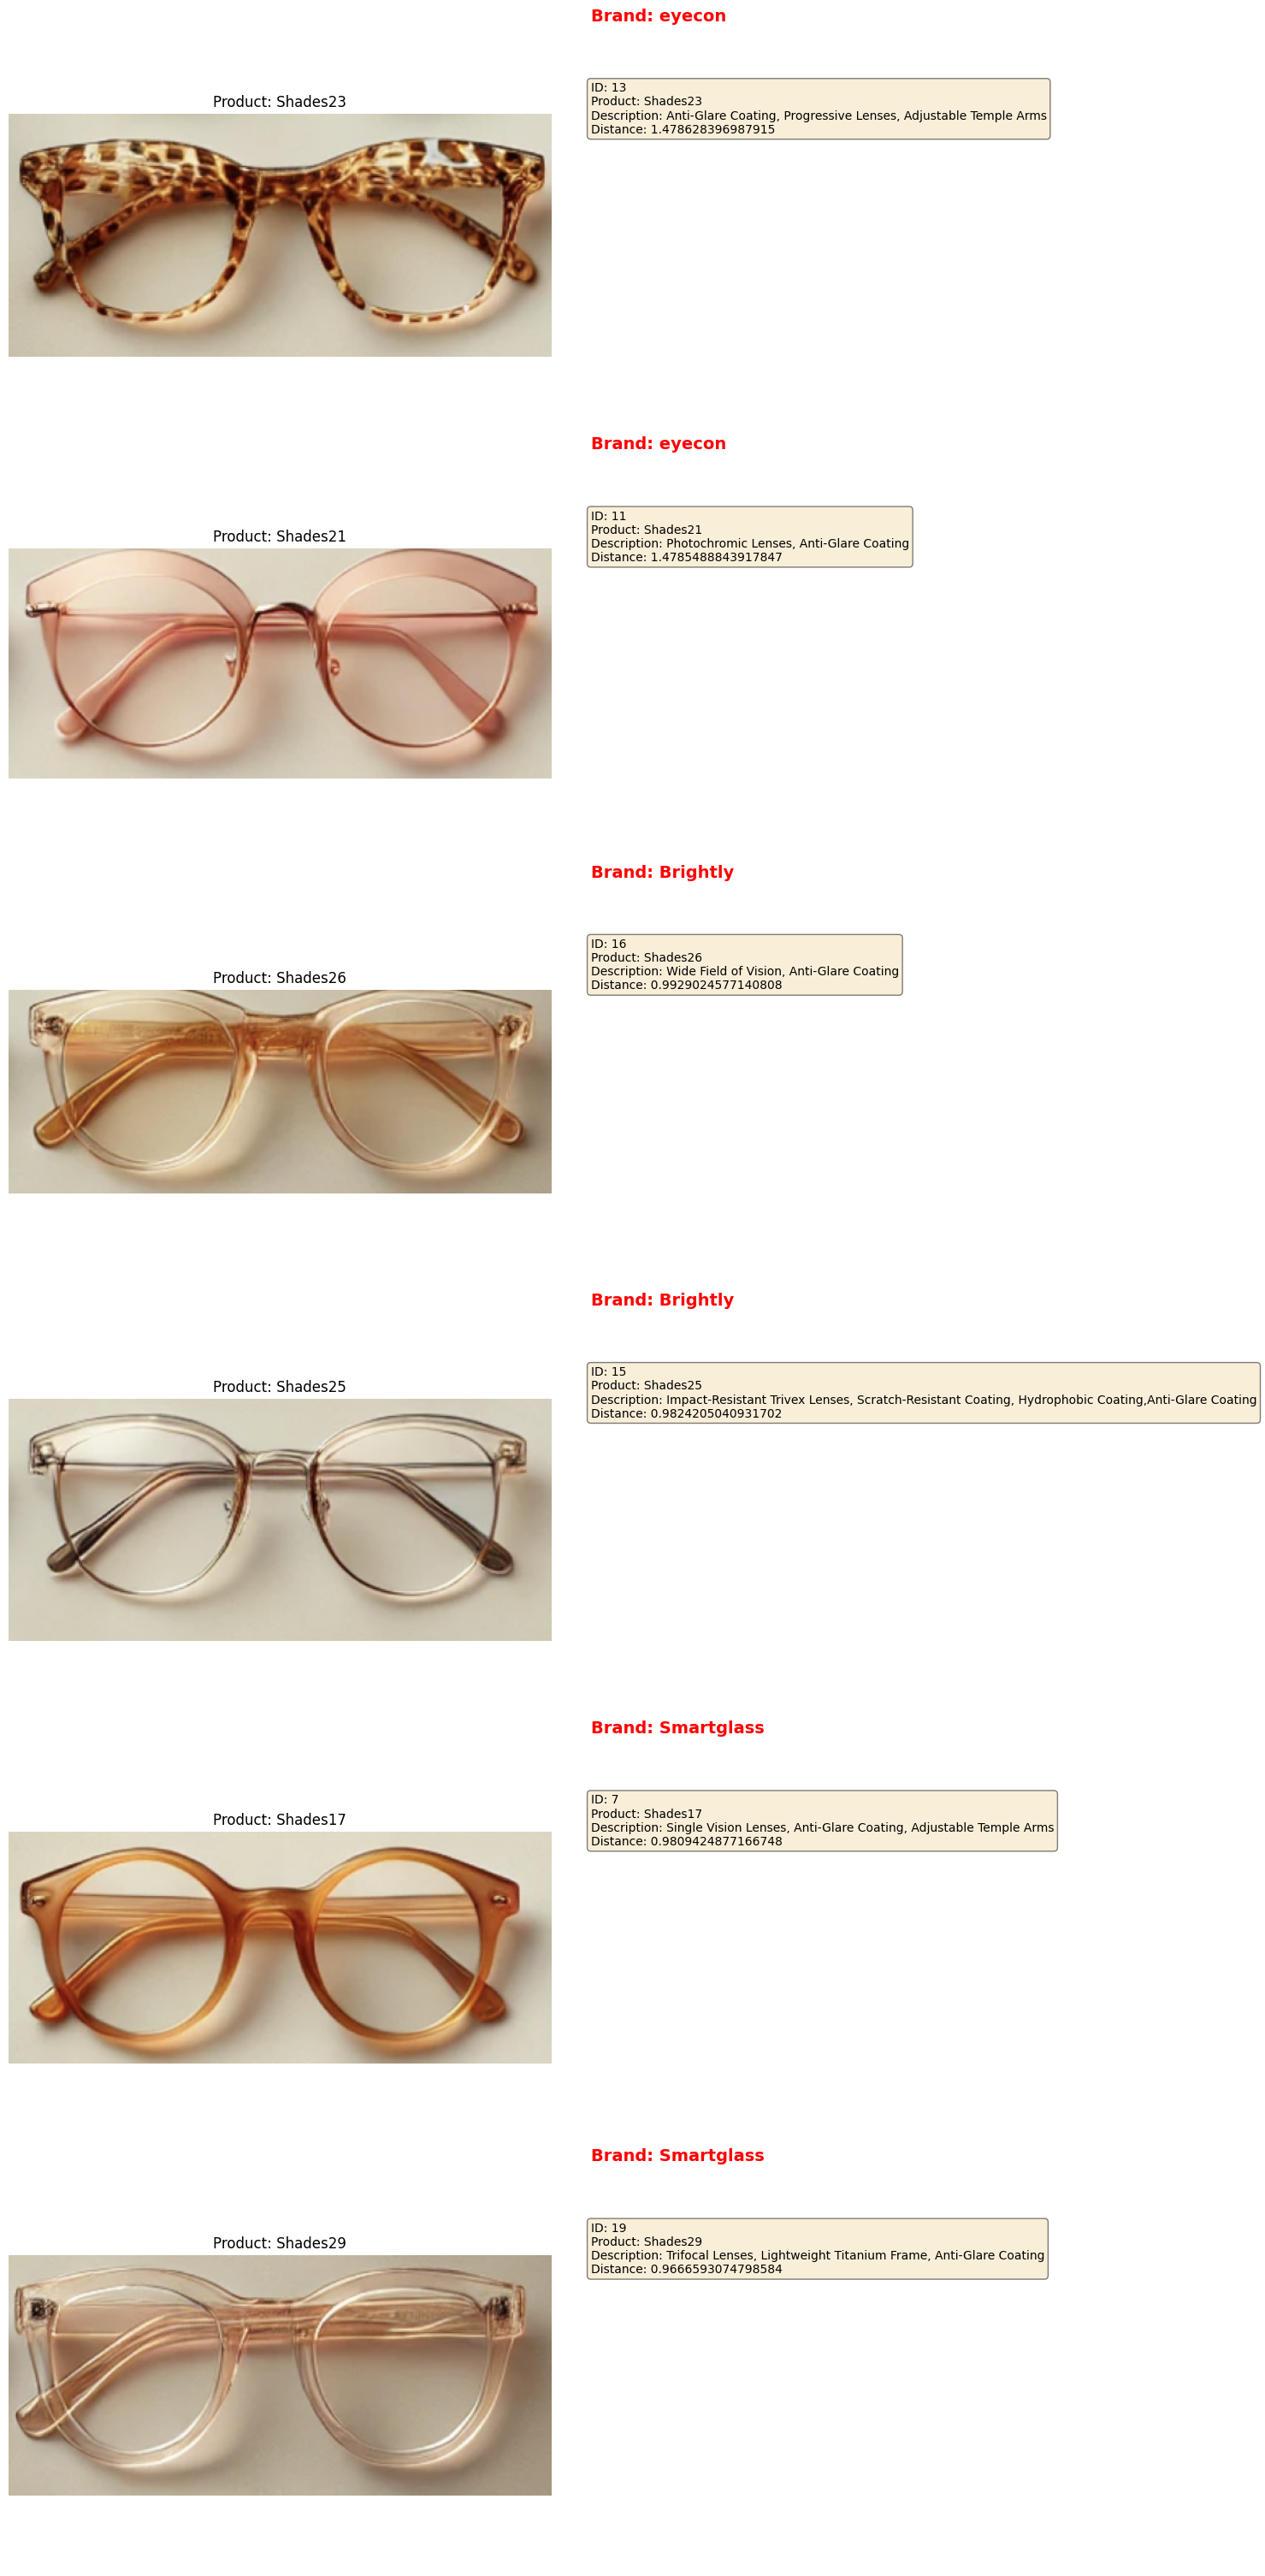

In [11]:
def hybrid_search(image_path, text_query, alpha=0.5, top_k=3):

    image_embedding = extract_image_embedding(image_path)
    splade_query_embedding = splade_ef.encode_queries([text_query])
    query_sparse_embedding = convert_sparse_embedding(splade_query_embedding)[0]
    search_param_image = {
        "data": [image_embedding],
        "anns_field": "image_embedding",
        "param": {
            "metric_type": "L2",
            "params": {"nprobe": 10}
        },
        "limit": top_k
    }
    request_image = AnnSearchRequest(**search_param_image)
    
    search_param_text = {
        "data": [query_sparse_embedding],
        "anns_field": "sparse_embedding",
        "param": {
            "metric_type": "IP",
            "params": {"drop_ratio_search": 0.2}
        },
        "limit": top_k
    }
    request_text = AnnSearchRequest(**search_param_text)
    
    rerank = WeightedRanker(alpha, 1 - alpha)

    collection.load()
    res = collection.hybrid_search(
        [request_image, request_text],
        rerank,
        limit=top_k,
        group_by_field="brand_name",# Applying group_by_field on "brand_name" field , to group the results according to brand
        group_size=2, # Applying group_size=2 , so that from each brand we get top 2 results 
        strict_group_size=True,
        output_fields=[
            "id", 
            "brand_name", 
            "product_name", 
            "product_description", 
            "image_path"
            ]
    )
    
    return res[0]
#Query 
image_path = "/root/sunglass/16.png"
text_query = "Anti-Glare Coating"

search_results = hybrid_search(image_path, text_query, alpha=0.5)

show_results(search_results)

#### After applying Hybrid + Grouping Search, we can see more diverse results, ensuring a balanced representation across brands. Since we set group_size=2, we retrieved the top 2 results per brand. Additionally, with topK=3, we obtained results from the top 3 brands, showcasing a well-distributed outcome.

## Conclusion :
In hybrid search, both image and textual features are combined to perform similarity search. Hybrid Search lays the foundation for accurate and relevant search results, but without diversity control, users may end up with repetitive recommendations from the same entity. This is where Grouping Search steps in — by structuring results into meaningful groups, it ensures a well-rounded and balanced search experience.

However, the effectiveness of Hybrid + Grouping Search depends on your dataset and use case. If diversity in results is crucial — such as in e-commerce, job searches, or content recommendations — Grouping Search can significantly enhance user experience. But in cases where strict similarity ranking is more important, a pure Hybrid Search might be the better approach.

By choosing the right strategy based on your dataset and needs, you can ensure optimized, efficient, and user-friendly search results. With Milvus, we’re not just searching — we’re searching smarter.